In [1]:
from modelhub import ModelHub
modelhub = ModelHub(time_aggregation='%Y-%m-%d')

In [2]:
df = modelhub.get_objectiv_dataframe(start_date='2021-11-16')
df['is_new_user'] = modelhub.map.is_new_user(df)

In [3]:
modelhub.add_conversion_event(
    location_stack=df.location_stack.json[{'id': 'Quickstart Guide', '_type': 'LinkContext'}:],
    event_type='PressEvent',
    name='quickstart_presses'
)
df['conversion_events'] = modelhub.map.is_conversion_event(df, 'quickstart_presses')
df['is_new_user_month'] = modelhub.map.is_new_user(df, time_aggregation='%Y-%m')
df['is_twice_converted'] = modelhub.map.conversions_in_time(df, name='quickstart_presses') == 2

unique_users = modelhub.aggregate.unique_users(df[df.is_new_user_month & df.is_twice_converted])

## Creating graph usign Graphviz

In [4]:
from sql_models.model import SqlModel
from bach.merge import MergeSqlModel
import numpy as np
from graphviz import Digraph

In [5]:
graph = Digraph(
    node_attr={
        'style': 'filled',
        'fontsize': '8',
        'scale': '0.5',
        'shape': 'plaintext',
        'fillcolor': 'white',
    }
)
# track existing sql nodes/vertices in graph
added_nodes = []

In [6]:
def add_node_references(current_node: SqlModel) -> None:
    # add current node to graph
    target = add_node_as_vertex(current_node)
    # add edges with ref nodes
    for ref_name, ref in current_node.references.items():
        node_target = target
        if isinstance(current_node, MergeSqlModel):
            # ref_name is left_node or right_node
            node_target = f'{target}:{ref_name}'
             
        graph.edge(ref.hash, node_target)
        
        if ref.hash not in added_nodes:
            add_node_references(ref)


In [7]:
COLUMNS_PER_ROW = 3
NODE_LABEL_TEMPLATE = (
'<<TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">'
'<TR><TD BGCOLOR="#abe9fe" ROWSPAN="{total_column_rows}"><b>{node_name}</b></TD> </TR>'
'{column_rows_tags}'
'</TABLE>>'
)

COLUMN_NAME_COLUMN_TEMPLATE = '<TD BGCOLOR="#fef284" COLSPAN="{col_span}">{col}</TD>'

def get_column_names_rows(current_node: SqlModel):
    col_names = list(current_node.column_expressions.keys())
    
    # split list of column names into equal-sized sub lists
    col_names_per_row = np.array_split(
        np.array(col_names), np.ceil(len(col_names)/COLUMNS_PER_ROW)
    )
    
    row_tags = []
    for c_row in col_names_per_row:
        col_tags = []
        for pos, col in enumerate(c_row):
            col_span = 1
            
            # make the last col span bigger if the number of columns is less than the expected
            if len(c_row) < COLUMNS_PER_ROW and pos == len(c_row) - 1:
                col_span = COLUMNS_PER_ROW - pos

            col_tag = COLUMN_NAME_COLUMN_TEMPLATE.format(col=col, col_span=col_span)
            col_tags.append(col_tag)

        row_tags.append(f"<TR>{''.join(col_tags)}</TR>")
    
    return row_tags
    

def add_node_as_vertex(current_node: SqlModel) -> str:    
    column_name_rows = get_column_names_rows(current_node)
    node_name = f'{current_node.generic_name}_{current_node.hash}'
    label = NODE_LABEL_TEMPLATE.format(
        total_column_rows=len(column_name_rows) + 1,
        node_name=node_name,
        column_rows_tags=''.join(column_name_rows)
    )
    
    # add current node to graph
    graph.node(name=current_node.hash, label=label)
    added_nodes.append(current_node.hash)
    
    # add a node for merge information
    # and make references create edges to merge info node instead
    if isinstance(current_node, MergeSqlModel):
        return add_merge_info_node(current_node)
    
    return current_node.hash

In [8]:
import re
def get_join_type(current_node: MergeSqlModel) -> str:
    join_regex = re.compile(r'.*(?P<join_type>left|right|outer|cross|inner).+join.*', re.S | re.I)
    return join_regex.match(current_node.sql).group('join_type')

MERGE_INFO_LABEL_TEMPLATE = (
    '{'
    '<join_type>{join_type} JOIN ON|'
    '{<left_node>left |{left_on}}'
    '{<right_node>right|{right_on}}'
    '}'
)
def add_merge_info_node(merge_node: MergeSqlModel) -> str:
    graph.attr('node', fillcolor='#fba99d', shape='record')
    
    join_type = get_join_type(merge_node)
    
    merge_node_name = f'{merge_node.hash}_merge'
    label = (
        '{'
        f'<join_type>{join_type.upper()} JOIN ON|'
        '{<left_node>left |<right_node>right}|'
        '{'
        f'{"|".join(merge_node.merge_on.left)}'
        f'|{"|".join(merge_node.merge_on.right)}'
        '}'
        '}'
    )
    graph.node(name=merge_node_name, label=label)
    
    # create edge to result merge
    graph.edge(f'{merge_node_name}', merge_node.hash)
    
    graph.attr('node', shape='plaintext', fillcolor='white')
    return merge_node_name

In [9]:
# initialize graph based on final base_node
add_node_references(unique_users.base_node)

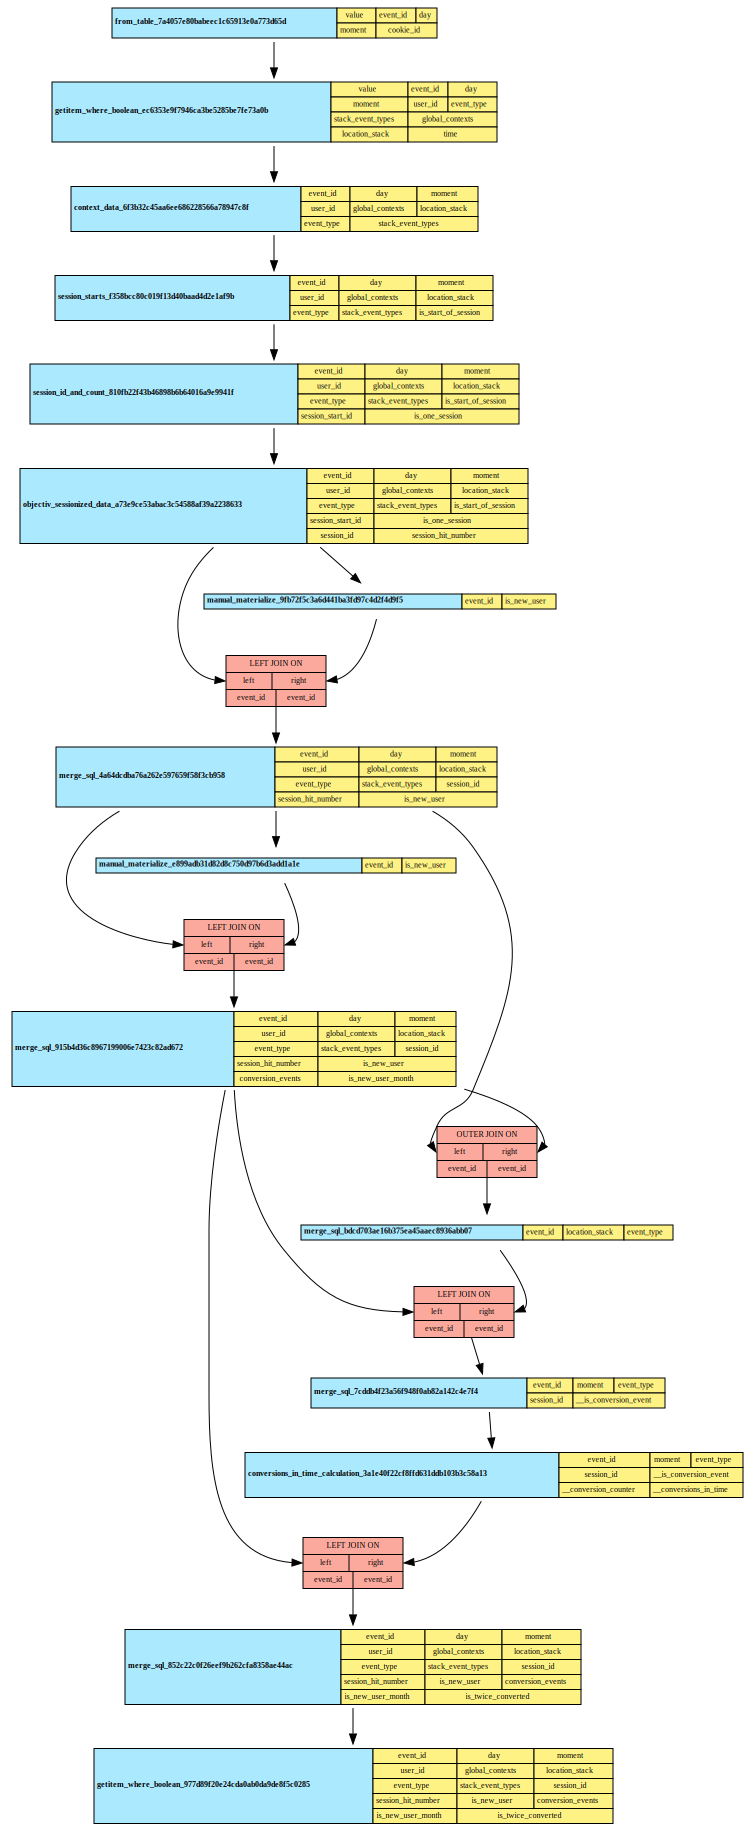

In [10]:
graph